In [ ]:
from __future__ import print_function

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
batch_size = 64
num_classes = 10
epochs = 200

In [ ]:
## DEF A BLOCK CONV + BN + GN + MAXPOOL
def CBGN(model,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same'))
  
  model.add(BN())
  model.add(GN(0.1))
  model.add(Activation('relu'))
  model.add(Conv2D(filters, (3, 3), padding='same'))
  model.add(BN())
  model.add(GN(0.2))
  model.add(Activation('relu'))
  model.add(Conv2D(filters, (3, 3), padding='same'))
  model.add(BN())
  model.add(GN(0.3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  
  return model

In [ ]:
#### LOAD AND TRANSFORM
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)

y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

170498071/170498071 [==============================] - 7s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
## DEFINE A DATA AUGMENTATION GENERATOR

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range = 0.2)

In [ ]:
## DEF NN TOPOLOGY  
model = Sequential()

model=CBGN(model,32,x_train.shape[1:])

model=CBGN(model,64)
model.add(Dropout(0.1))

model=CBGN(model,128)
model.add(Dropout(0.2))

model=CBGN(model,256)
model.add(Dropout(0.3))

model=CBGN(model,512)
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 gaussian_noise (GaussianNoi  (None, 32, 32, 32)       0         
 se)                                                             
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       1

In [ ]:
# Early Stopping
es = EarlyStopping(
    monitor='val_loss',
    patience=100,
    verbose=1,
    mode=min
)

In [ ]:
#Checkpoint
mc = ModelCheckpoint(
    'best_m.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience = 15)

In [ ]:
def plot_evolution(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Epoch 1/200

Epoch 1: val_accuracy improved from -inf to 0.29860, saving model to best_m.h5
781/781 - 51s - loss: 2.0136 - accuracy: 0.2118 - val_loss: 1.8271 - val_accuracy: 0.2986 - lr: 0.0010 - 51s/epoch - 66ms/step
Epoch 2/200

Epoch 2: val_accuracy improved from 0.29860 to 0.39190, saving model to best_m.h5
781/781 - 41s - loss: 1.6410 - accuracy: 0.3555 - val_loss: 1.8860 - val_accuracy: 0.3919 - lr: 0.0010 - 41s/epoch - 52ms/step
Epoch 3/200

Epoch 3: val_accuracy improved from 0.39190 to 0.55860, saving model to best_m.h5
781/781 - 40s - loss: 1.3782 - accuracy: 0.4903 - val_loss: 1.2723 - val_accuracy: 0.5586 - lr: 0.0010 - 40s/epoch - 52ms/step
Epoch 4/200

Epoch 4: val_accuracy improved from 0.55860 to 0.62170, saving model to best_m.h5
781/781 - 39s - loss: 1.2030 - accuracy: 0.5672 - val_loss: 1.0940 - val_accuracy: 0.6217 - lr: 0.0010 - 39s/epoch - 51ms/step
Epoch 5/200

Epoch 5: val_accuracy improved from 0.62170 to 0.62300, saving model to best_m.h5
781/781 - 39s - loss

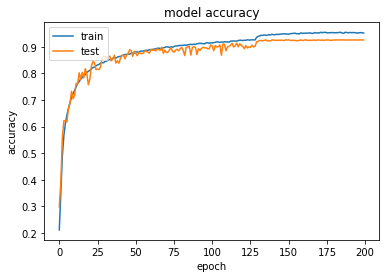

In [ ]:
## TRAINING with DA
history=model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[es,mc, reduce_lr],
                            verbose=2)
plot_evolution(history)

In [ ]:
## TEST
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 4s 13ms/step - loss: 0.2389 - accuracy: 0.9258
Test loss: 0.23891213536262512
Test accuracy: 0.9258000254631042


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# load the saved model
saved_model = load_model('best_m.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(x_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.984, Test: 0.927
